In [446]:
import numpy as np
import matplotlib.pyplot as plt
import pywt 
import itertools
from imageio import imread
from scipy.signal import wiener,medfilt
from skimage.util.shape import view_as_blocks
from skimage.measure import compare_psnr
from skimage.measure import compare_mse
from skimage.measure import compare_nrmse

In [447]:
def genMeas(img,Phi,blkShape):
    ''' Generate list of measurement vectors in raster scanning order
        input: 
            img, 2d array, the original image,
            blkShape, tuple, the shape of each sensing block.
            Phi, M by N the measurement matrix
        output:
            y, a list of measurement vectors, length of y is the number of blocks
    '''
    assert img.shape[0]%blkShape[0] == 0
    assert img.shape[1]%blkShape[1] == 0
    y = []
    for (i,j) in itertools.product(range(int(img.shape[0]/blkShape[0])),range(int(img.shape[1]/blkShape[1]))):
        blk = img[i*blkShape[0]:(i+1)*blkShape[0],j*blkShape[1]:(j+1)*blkShape[1]]
        x = blk.flatten()
        y.append(Phi.dot(x))
    return y

In [363]:
def thres(x,wType,lamda,level):
    ''' threshold in wavelet domain and reconstruction
        input: x, 2d array
               lamda, clipping threshold
               level, scalar, integer of wavelet transform level
        output: 
            xR, reconstruction of x using clipped coefficients.
    '''
    coeff = pywt.wavedec2(x,wType,'symmetric',level)
    coeff_arr,coeff_slices = pywt.coeffs_to_array(coeff)
    tau = genTau(lamda,coeff_arr)
    coeff_cut = pywt.threshold(coeff_arr,tau,'hard')
    coeff_cut = pywt.array_to_coeffs(coeff_cut,coeff_slices,output_format='wavedec2')
    xR = pywt.waverec2(coeff_cut,wType)
    return xR

In [492]:
def shrinkage(x,Phi,y,blkShape,gamma):
    ''' The shrinkage step in the shinkage thresholding method
        input: 
            x, the image before block shrinkage step
            Phi, the Measurement matrix
            y, list of measurment result of each block
            blkShape, shape of blocks
        output:
            x, the image after the shrinkage step
    '''
    assert x.shape[0]%blkShape[0] == 0
    assert x.shape[1]%blkShape[1] == 0
    iterIdx = 0
    for (i,j) in itertools.product(range(int(x.shape[0]/blkShape[0])),range(int(x.shape[1]/blkShape[1]))):
        blk = x[i*blkShape[0]:(i+1)*blkShape[0],j*blkShape[1]:(j+1)*blkShape[1]]
        blk=blk.flatten()
        result = np.reshape(blk+gamma*Phi.T.dot(y[iterIdx]-Phi.dot(blk)),blkShape)
        x[i*blkShape[0]:(i+1)*blkShape[0],j*blkShape[1]:(j+1)*blkShape[1]] = result
        iterIdx+=1
    return x

In [515]:
def accSPL(x, y, t, Phi, lamda, gamma, blkShape,wType='db1',level=1):
    ''' One iteration of Smooth Projected Landweber algorithm
        input:
            x, image at iteration k
            xPrev, image at iteration k-1
            y, list of measurement vectors
            Phi, Measurment Matrix
            wType, wavelet Type, defualt Daubechies 1
            level, level of wavelet transform
            lamda, thresholding value
            blkShape, block shape of each sub blocks
        output
            x1, image at iteration k+1
    '''
    x = wiener(x,3)
    xS = shrinkage(x,Phi,y,blkShape,gamma) # First stage shrinkage followed by thresholding
    xT = thres(xS,wType,lamda,level)
    tNext = (1+np.sqrt(1+4*t**2))/2
    xT = xT+(t-1)/tNext*(xT-x)
    xS2 = shrinkage(xT,Phi,y,blkShape,gamma) # Second stage shrinkage followed by wiener filtering
    return xS2, tNext

In [516]:
def SPL(x, y, Phi, lamda, gamma, blkShape,wType='db1',level=1):
    ''' One iteration of Accelerated Smooth Projected Landweber algorithm
        input:
            x, image at iteration k
            y, list of measurement vectors
            Phi, Measurment Matrix
            wType, wavelet Type, defualt Daubechies 1
            level, level of wavelet transform
            lamda, thresholding value
            blkShape, block shape of each sub blocks
        output
            x1, image at iteration k+1
    '''
    x = wiener(x,3)
    xS = shrinkage(x,Phi,y,blkShape,gamma)   # stage 1 shrinkage, followed by thresholding
    xT = thres(xS,wType,lamda,level)
    xS2 = shrinkage(xT,Phi,y,blkShape,gamma)   # stage 1 shrinkage, followed by thresholding
    return xS2

In [517]:
def genPhi(M,blkShape):
    ''' Generate measurement matrix with normalized row vectors 
    '''
    Phi = np.random.randn(M,blkShape[0]*blkShape[1]); # Measurement fat Matrix
    for i in range(M):
        Phi[i,:] = Phi[i,:]/np.linalg.norm(Phi[i,:])
    return Phi

In [518]:
def genTau(lamda,coeff_array):
    ''' Adaptively Generate thresholding value in each iteration
    '''
    sigma = np.median(np.abs(coeff_array))/0.6745
    K = len(coeff_array)
    tau = lamda*sigma*np.sqrt(2*np.log10(K))
    return tau

In [519]:
def genInit(Phi,y,blkShape,imgShape):
    ''' Generate initial approximation x
    '''
    iterIdx = 0
    x0 = np.zeros(imgShape)
    for (i,j) in itertools.product(range(int(imgShape[0]/blkShape[0])),range(int(imgShape[1]/blkShape[1]))):
        x0[i*blkShape[0]:(i+1)*blkShape[0],j*blkShape[1]:(j+1)*blkShape[1]] = np.reshape(Phi.T.dot(y[iterIdx]),blkShape)
        iterIdx+=1
    return x0

## Accelerated Smooth Projected Landweber Iteration

In [520]:
img = imread('./images/lenna.png')
wType = 'db8'                                        # wavelet Type
blkShape = (8,8)                                     # Shape of each block of image
M = 32                                               # Dimension of measurement vector
lamda = 1                                            # Thresholding value
level = None                                         # wavelet level
Phi = genPhi(M,blkShape)                             # Measurement fat Matrix
gamma = 1/abs(np.linalg.eigh(Phi.T.dot(Phi))[0][-1])
y = genMeas(img,Phi,blkShape)                        # Measurements associate with each blocks

In [521]:
x = genInit(Phi,y,blkShape,img.shape)
xAcc = genInit(Phi,y,blkShape,img.shape)
maxIter = 200;
psnrAccSPL = np.zeros(maxIter)
psnrSPL = np.zeros(maxIter)
t = 1
for i in range(maxIter):
    x = SPL(x, y, Phi, lamda, gamma, blkShape,wType=wType,level=level)
    xAcc,t = accSPL(xAcc, y, t, Phi, lamda, gamma, blkShape,wType=wType,level=level)
    psnrAccSPL[i] = compare_psnr(img,xAcc.astype('uint8'))
    psnrSPL[i] = compare_psnr(img,x.astype('uint8'))

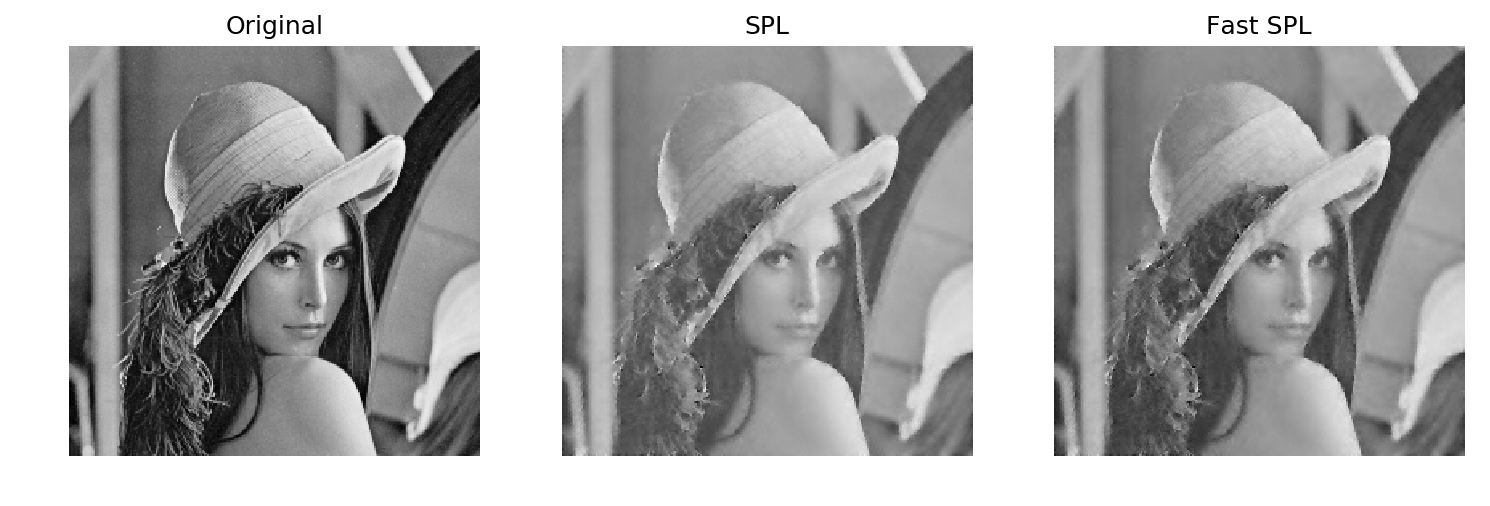

Text(0.5,0,'iteration')

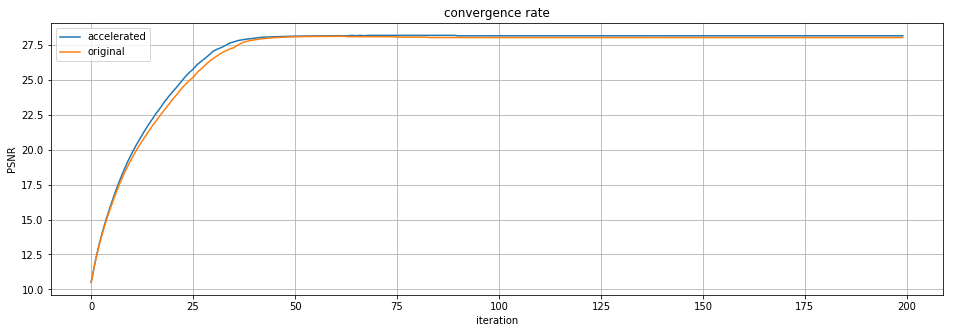

In [522]:
fig, axes = plt.subplots(1,3,figsize=(12,5),dpi=150)
axes[0].imshow(img,cmap='gray')
axes[0].axis("off")
axes[0].set_title('Original')
axes[1].imshow(x,cmap='gray')
axes[1].axis("off")
axes[1].set_title('SPL')
axes[2].imshow(xAcc,cmap='gray')
axes[2].axis("off")
axes[2].set_title('Fast SPL')
plt.show()

plt.figure(figsize=(16,5))
plt.plot(range(maxIter),psnrAccSPL,label='accelerated')
plt.plot(range(maxIter),psnrSPL,label='original')
plt.legend()
plt.grid()
plt.title('convergence rate')
plt.ylabel('PSNR')
plt.xlabel('iteration')